<a href="https://colab.research.google.com/github/jung-un/rl_toss_ad_optimization/blob/main/RL_TOSS_MAB_Stateless.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#폰트 설치/적용
!apt-get -qq install fonts-nanum > /dev/null

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import numpy as np


# 폰트 경로 등록 및 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='NanumGothic', style='whitegrid')


#ε-Greedy(고정형)

[PARAM] eps_greedy | T=100000, EPS=0.1, SEED=42, PATH='Toss_preprocessed_FF.csv'
[ENV] #arms=8, p*=0.3644, mean(p)=0.2894
[ε-Greedy] final CTR=0.3529 (best=0.3644)


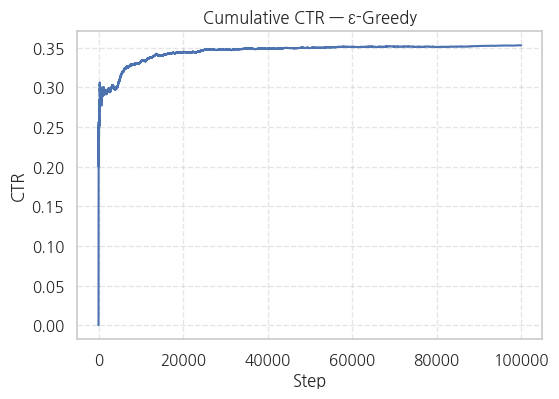

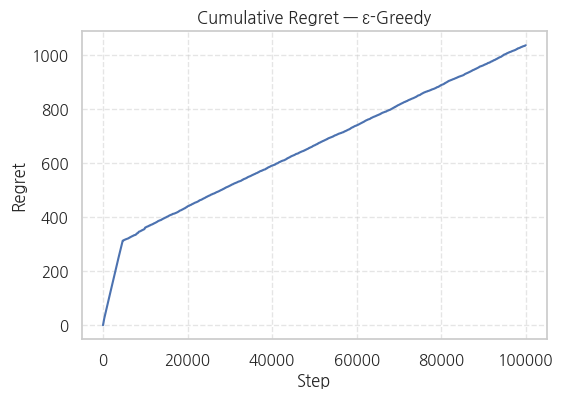

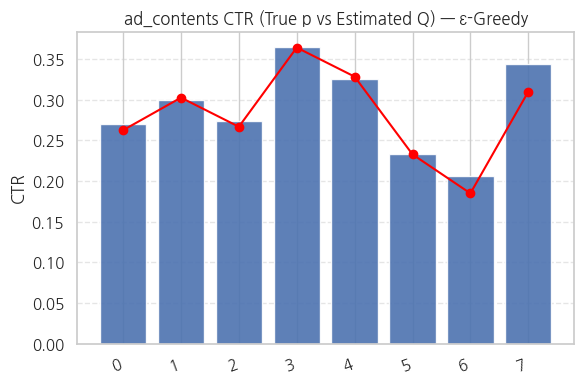

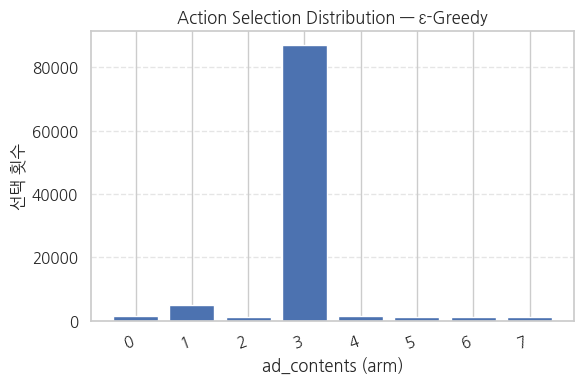

In [ ]:
# -*- coding: utf-8 -*-
"""
Stateless ε-Greedy on CSV (ad_contents, reward)

[실험 파라미터]
- PATH:              CSV 경로
- T:                 총 스텝 수(에피소드 길이)
- EPS:               ε (탐색 확률), 고정값
- SEED:              난수 시드(재현성)
"""
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ==== [실험 파라미터] ====
PATH = "Toss_preprocessed_FF.csv"
T    = 100_000           # 총 스텝
EPS  = 0.10              # 고정 탐색률 ε
SEED = 42                # 재현성 시드
# ========================

print(f"[PARAM] eps_greedy | T={T}, EPS={EPS}, SEED={SEED}, PATH='{PATH}'")

def load_bandit_from_csv(path, ad_col="ad_contents", reward_col="reward", seed=SEED):
    """
    CSV로부터 정적 밴딧 환경 p(a)=CTR을 구성.
    - 라플라스 스무딩: p = (clicks+1) / (n+2)
    - step(a): Bernoulli(p[a])에서 보상(0/1) 샘플
    """
    rng = np.random.default_rng(seed)
    df = pd.read_csv(path)
    assert {ad_col, reward_col}.issubset(df.columns)
    df = df[df[reward_col].isin([0, 1])].copy()

    # [팔 라벨]을 0..K-1로 매핑(내부 인덱스 안정화)
    arms, inv = np.unique(df[ad_col].values, return_inverse=True)
    df["_arm"] = inv

    # 팔별 CTR 추정(라플라스 스무딩)
    g = df.groupby("_arm")[reward_col].agg(n="count", clicks="sum")
    p = ((g["clicks"] + 1) / (g["n"] + 2)).to_numpy(dtype=float)  # shape [K]
    labels = arms.tolist()

    def step(a: int) -> int:
        """에이전트가 선택한 팔 a에 대해 보상을 무작위 샘플링"""
        return int(rng.random() < p[a])

    return p, labels, step

# ----- 환경 로드 -----
p, labels, step = load_bandit_from_csv(PATH, seed=SEED)
K = len(p)
p_star = float(p.max())  # 최적 팔의 CTR(이론적 상한, regret 계산용)
print(f"[ENV] #arms={K}, p*={p_star:.4f}, mean(p)={p.mean():.4f}")

# ----- 상태 변수 초기화 -----
n = np.zeros(K, dtype=int)     # 팔별 시행 수
s = np.zeros(K, dtype=float)   # 팔별 누적 보상
Q = np.zeros(K, dtype=float)   # 팔별 평균 보상(추정 CTR)

ctr_curve    = np.zeros(T)     # t 시점까지의 누적 CTR
regret_curve = np.zeros(T)     # 누적 regret(기대치 기준)

def choose(t: int) -> int:
    """
    ε-탐색/1-ε-활용 정책
    - 감쇠형을 쓰고 싶으면: eps = EPS / np.sqrt(t)
    """
    eps = EPS
    if np.random.random() < eps:
        return np.random.randint(K)            # 무작위 탐색
    return int(np.argmax(Q))                   # 현재 최고 추정치 활용

# ----- 주 루프 -----
for t in range(1, T + 1):
    a = choose(t)
    r = step(a)

    # 관측 업데이트
    n[a] += 1
    s[a] += r
    Q[a]  = s[a] / n[a]

    # 성능 곡선 업데이트
    ctr_curve[t - 1]    = s.sum() / t
    regret_curve[t - 1] = (p_star - p[a]) + (0 if t == 1 else regret_curve[t - 2])

print(f"[ε-Greedy] final CTR={ctr_curve[-1]:.4f} (best={p_star:.4f})")

# ----- 시각화 1) 누적 CTR -----
plt.figure(figsize=(6, 4))
plt.plot(ctr_curve)
plt.title("Cumulative CTR — ε-Greedy")
plt.xlabel("Step"); plt.ylabel("CTR")
plt.grid(True, ls="--", alpha=0.5); plt.show()

# ----- 시각화 2) 누적 Regret -----
plt.figure(figsize=(6, 4))
plt.plot(regret_curve)
plt.title("Cumulative Regret — ε-Greedy")
plt.xlabel("Step"); plt.ylabel("Regret")
plt.grid(True, ls="--", alpha=0.5); plt.show()

# ----- 시각화 3) 컨텐츠별 실제 CTR vs 학습 추정 CTR -----
order = np.arange(K)  # 실제 CTR 내림차순 정렬
plt.figure(figsize=(6, 4))
plt.bar(range(K), p[order], alpha=0.9)        # 실제 CTR (환경)
plt.plot(range(K), Q[order], marker="o", color='red')      # 학습 추정 CTR
plt.xticks(range(K), [str(labels[i]) for i in order], rotation=20, ha="right")
plt.title("ad_contents CTR (True p vs Estimated Q) — ε-Greedy")
plt.ylabel("CTR"); plt.grid(True, axis="y", ls="--", alpha=0.5)
plt.tight_layout(); plt.show()

# ----- 시각화 4) 팔 선택 분포 (횟수 기준) -----
plt.figure(figsize=(6, 4))

x = np.arange(K)  # arm index 0..K-1
plt.bar(x, n)     # n: 각 팔이 선택된 총 횟수

plt.xticks(x, [str(labels[i]) for i in range(K)],
           rotation=20, ha="right")
plt.title("Action Selection Distribution — ε-Greedy")
plt.xlabel("ad_contents (arm)")
plt.ylabel("선택 횟수")
plt.grid(True, axis="y", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()



#결과저장
import numpy as np  # 이미 위에서 했다면 생략 가능

np.savez(
    "/content/eps_fixed_result.npz",   # 파일명은 원하는 대로 변경 가능
    name="ε-Greedy(고정형)",
    ctr_curve=ctr_curve,
    regret_curve=regret_curve,
    Q=Q,
    n=n,
    p=p,
    labels=np.array(labels),
    final_ctr=float(ctr_curve[-1]),
    p_star=float(p_star)
)



#ε-Greedy(감쇠형)


[ENV] #arms=8, p*=0.3644, mean(p)=0.2894
[RESULT] Final CTR=0.3493


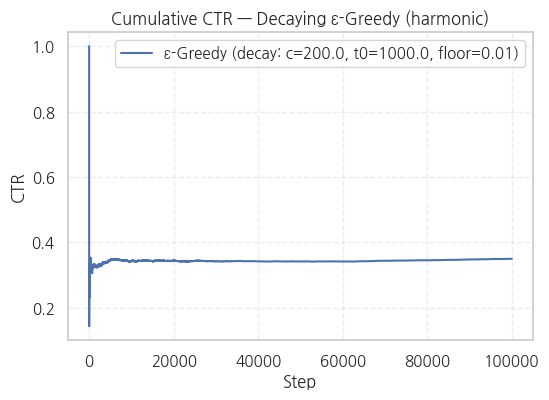

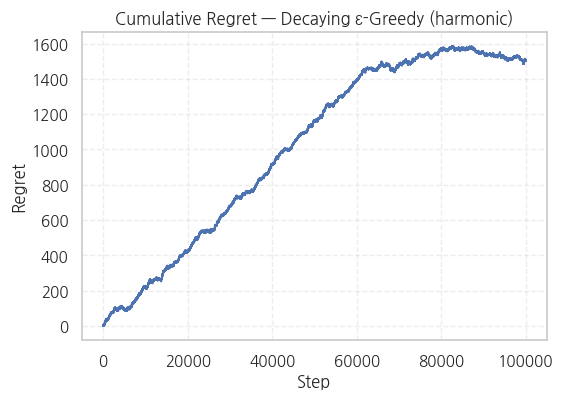

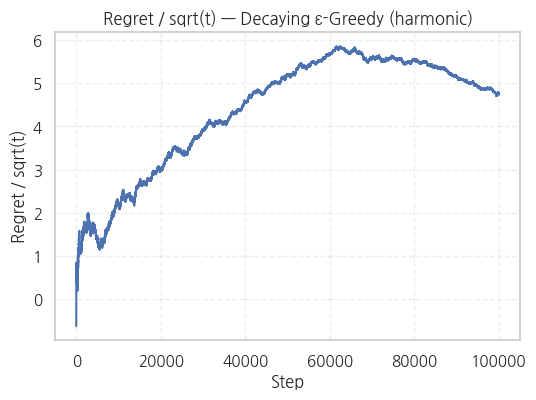

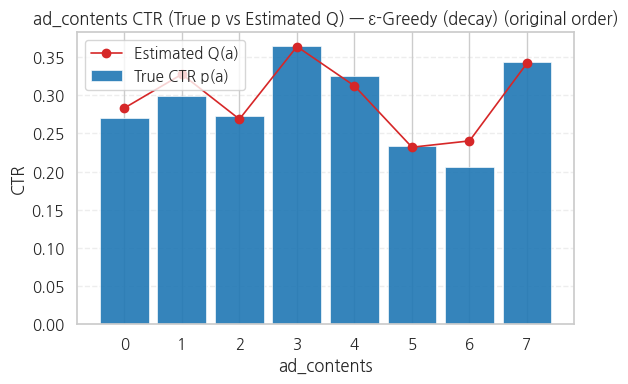

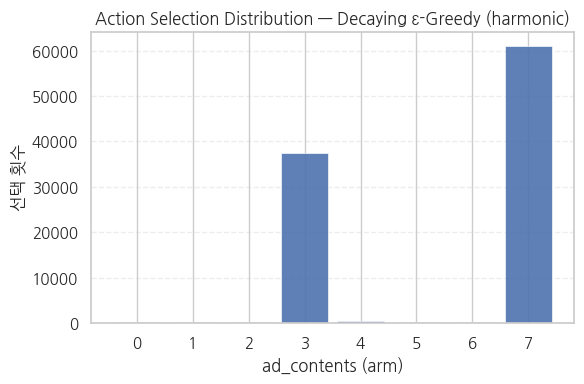

In [ ]:
# -*- coding: utf-8 -*-
"""
Decaying ε-Greedy (harmonic) for Bernoulli Bandit
- ε_t = max(EPS_MIN, min(1, C_HARM / (t + T0_HARM)))
- Warm-up (각 팔 최소 1회), 타이브레이크 랜덤화로 콜드스타트/동률편향 방지
- 그래프:
    1) 누적 CTR
    2) 누적 Regret
    3) Regret / sqrt(t)
    4) 팔별 실제 CTR vs 학습된 Q (정렬 선택 가능)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===================== 사용자 설정 =====================
PATH      = "Toss_preprocessed_FF.csv"  # ad_contents, reward 포함 CSV
AD_COL    = "ad_contents"
REWARD_COL= "reward"

T         = 100_000     # 총 스텝
SEED      = 42


# ε 감쇠(조화형): ε_t = c / (t + t0)
C_HARM    = 200.0        # ← 수정
T0_HARM   = 1000.0       # ← 그대로 사용
EPS_MIN   = 0.01         # ← 0.005 → 0.01 로 수정


WARM      = 1           # 각 팔 강제 시도 횟수(최소 1 추천)
SORT_ARMS = False       # 팔별 그래프 정렬: True=실제 CTR 내림차순, False=원래 순서

# ===================== 유틸 함수 =====================
def eps_t(t: int) -> float:
    """harmonic schedule with floor: ε_t = max(EPS_MIN, min(1, C_HARM/(t+T0_HARM)))"""
    return max(EPS_MIN, min(1.0, C_HARM / (t + T0_HARM)))

def load_bandit_from_csv(path, ad_col=AD_COL, reward_col=REWARD_COL, seed=SEED):
    """
    CSV → 팔별 베르누이 확률 p 추정(라플라스 평활) + step 함수
    - 반환: p(np.ndarray[K]), labels(list), step(callable: a->0/1)
    """
    rng = np.random.default_rng(seed)
    df = pd.read_csv(path)
    assert {ad_col, reward_col}.issubset(df.columns), "CSV에 ad_contents, reward 필요"
    df = df[df[reward_col].isin([0, 1])].reset_index(drop=True)

    # 라벨 → 0..K-1
    arms, inv = np.unique(df[ad_col].values, return_inverse=True)
    df["_arm"] = inv

    # 팔별 CTR 추정 (Laplace smoothing: (clicks+1)/(n+2))
    g = df.groupby("_arm")[reward_col].agg(n="count", clicks="sum")
    p = ((g["clicks"] + 1) / (g["n"] + 2)).to_numpy(float)
    labels = arms.tolist()

    def step(a: int) -> int:
        return int(rng.random() < p[a])

    return p, labels, step

# ===================== 환경 준비 =====================
p, labels, step = load_bandit_from_csv(PATH)
K       = len(p)
p_star  = float(p.max())
rng     = np.random.default_rng(SEED)
print(f"[ENV] #arms={K}, p*={p_star:.4f}, mean(p)={p.mean():.4f}")

# 상태 변수
n = np.zeros(K, dtype=int)       # 선택 횟수
s = np.zeros(K, dtype=float)     # 누적 보상
Q = np.zeros(K, dtype=float)     # 추정 CTR



ctr_curve    = np.zeros(T)
regret_curve = np.zeros(T)
cum_reward   = 0.0

# ---------- 워밍업: 각 팔 최소 WARM회 ----------
for a in range(K):
    for _ in range(WARM):
        r = step(a)
        n[a] += 1
        s[a] += r
        Q[a]  = s[a] / n[a]

# ===================== 메인 루프 =====================
for t in range(1, T + 1):
    eps = eps_t(t)

    if rng.random() < eps:                 # 탐색
        a = int(rng.integers(K))
    else:                                  # 활용 (동률 타이브레이크를 랜덤으로)
        a = int(np.argmax(Q + 1e-9 * rng.random(K)))

    r = step(a)

    # 샘플 평균 업데이트
    n[a] += 1
    s[a] += r
    Q[a]  = s[a] / n[a]

    cum_reward       += r
    ctr_curve[t - 1]  = cum_reward / t
    regret_curve[t-1] = t * p_star - cum_reward

print(f"[RESULT] Final CTR={ctr_curve[-1]:.4f}")

# ===================== 시각화 =====================
# 1) 누적 CTR
plt.figure(figsize=(6,4))
plt.plot(ctr_curve, label=f"ε-Greedy (decay: c={C_HARM}, t0={T0_HARM}, floor={EPS_MIN})")
plt.title("Cumulative CTR — Decaying ε-Greedy (harmonic)")
plt.xlabel("Step"); plt.ylabel("CTR"); plt.grid(True, ls="--", alpha=.35); plt.legend()
plt.show()

# 2) 누적 Regret
plt.figure(figsize=(6,4))
plt.plot(regret_curve)
plt.title("Cumulative Regret — Decaying ε-Greedy (harmonic)")
plt.xlabel("Step"); plt.ylabel("Regret"); plt.grid(True, ls="--", alpha=.35)
plt.show()

# 3) Regret / sqrt(t)  (서브선형 경향 체크)
plt.figure(figsize=(6,4))
plt.plot(regret_curve / np.sqrt(np.arange(1, T + 1)))
plt.title("Regret / sqrt(t) — Decaying ε-Greedy (harmonic)")
plt.xlabel("Step"); plt.ylabel("Regret / sqrt(t)"); plt.grid(True, ls="--", alpha=.35)
plt.show()

# 4) 팔별 실제 CTR vs 추정 Q
if SORT_ARMS:
    order = np.argsort(-p)   # 실제 CTR 내림차순
    suffix = "(sorted by True CTR)"
else:
    order = np.arange(K)     # 원래 순서 유지
    suffix = "(original order)"

p_plot    = p[order]
Q_plot    = Q[order]
labs_plot = [str(labels[i]) for i in order]
x         = np.arange(K)

plt.figure(figsize=(6,4))

# 파란 막대: 실제 CTR
plt.bar(
    x, p_plot,
    width=0.85,
    alpha=0.9,
    edgecolor="white",
    linewidth=0.5,
    color="tab:blue",
    label="True CTR p(a)"
)

# 빨간 선 + 동그라미: 학습된 Q
plt.plot(
    x, Q_plot,
    marker="o",
    linewidth=1.2,
    color="tab:red",
    label="Estimated Q(a)"
)

plt.xticks(x, labs_plot)
plt.xlabel("ad_contents")
plt.ylabel("CTR")
plt.title(f"ad_contents CTR (True p vs Estimated Q) — ε-Greedy (decay) {suffix}")
plt.grid(True, axis="y", linestyle="--", alpha=.35)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# 5) Action Selection Distribution — 선택 횟수 기준
# Q값 그래프에서 쓰던 order/SORT_ARMS 설정을 그대로 활용

n_plot = n[order]                 # 정렬 여부(SORT_ARMS)에 맞춰 선택 횟수도 같은 순서로 정렬
x      = np.arange(K)
labs_plot = [str(labels[i]) for i in order]

plt.figure(figsize=(6,4))
plt.bar(x, n_plot, width=0.85, alpha=0.9, edgecolor="white", linewidth=0.5)

plt.xticks(x, labs_plot)
plt.xlabel("ad_contents (arm)")
plt.ylabel("선택 횟수")
plt.title("Action Selection Distribution — Decaying ε-Greedy (harmonic)")
plt.grid(True, axis="y", linestyle="--", alpha=.35)
plt.tight_layout()
plt.show()


#결과저장

np.savez(
    "/content/eps_decay_result.npz",
    name="ε-Greedy(감쇠형)",
    ctr_curve=ctr_curve,
    regret_curve=regret_curve,
    Q=Q,
    n=n,
    p=p,
    labels=np.array(labels),
    final_ctr=float(ctr_curve[-1]),
    p_star=float(p_star)
)


#Softmax(고정형)

[PARAM] softmax_fixed | T=100000, T0=0.5, SEED=42, PATH='Toss_preprocessed_FF.csv'
[ENV] #arms=8, p*=0.3644, mean(p)=0.2894
[Softmax fixed] final CTR=0.2939 (best=0.3644)


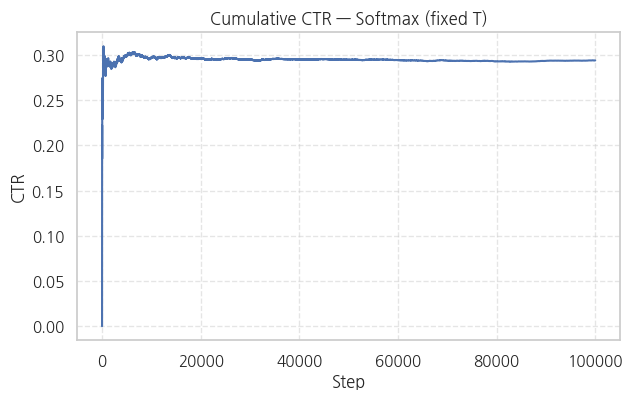

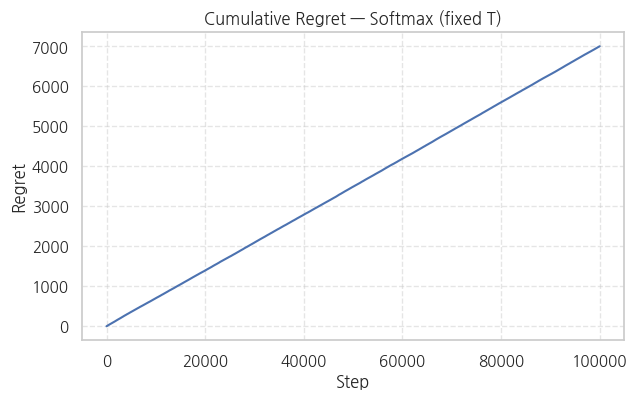

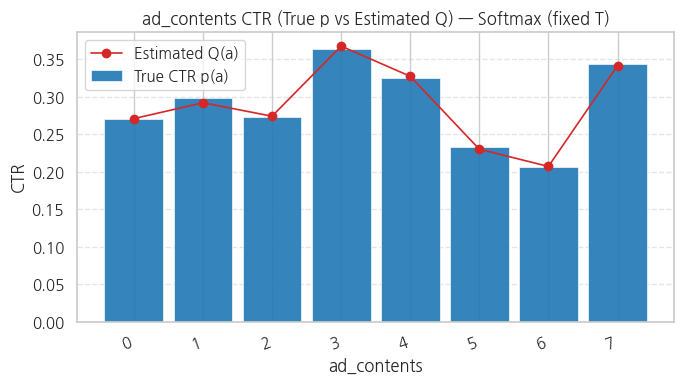

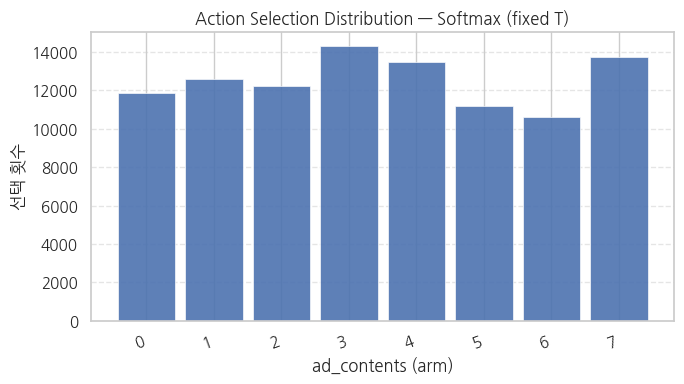

In [ ]:
# -*- coding: utf-8 -*-
"""
Stateless Softmax (고정형) on CSV (ad_contents, reward)

[실험 파라미터]
- PATH:  CSV 경로
- T:     총 스텝 수
- T0:    온도(temperature, 클수록 탐색 ↑, 작을수록 활용 ↑)
- SEED:  난수 시드
"""
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ==== [실험 파라미터] ====
PATH  = "Toss_preprocessed_FF.csv"
T     = 100_000
T0    = 0.50        # 고정 온도 (temperature)
SEED  = 42
# ========================

np.random.seed(SEED)  # 전역 난수 시드 고정 (에이전트용)

print(f"[PARAM] softmax_fixed | T={T}, T0={T0}, SEED={SEED}, PATH='{PATH}'")

def load_bandit_from_csv(path, ad_col="ad_contents", reward_col="reward", seed=SEED):
    rng = np.random.default_rng(seed)   # 환경용 난수 시드
    df = pd.read_csv(path)
    assert {ad_col, reward_col}.issubset(df.columns)
    df = df[df[reward_col].isin([0, 1])].copy()

    # 라벨 → 0..K-1
    arms, inv = np.unique(df[ad_col].values, return_inverse=True)
    df["_arm"] = inv

    # 팔별 CTR 추정 (Laplace smoothing: (clicks+1)/(n+2))
    g = df.groupby("_arm")[reward_col].agg(n="count", clicks="sum")
    p = ((g["clicks"] + 1) / (g["n"] + 2)).to_numpy(dtype=float)
    labels = arms.tolist()

    def step(a: int) -> int:
        return int(rng.random() < p[a])

    return p, labels, step

# ==== 환경 준비 ====
p, labels, step = load_bandit_from_csv(PATH, seed=SEED)
K      = len(p)
p_star = float(p.max())
print(f"[ENV] #arms={K}, p*={p_star:.4f}, mean(p)={p.mean():.4f}")

# 상태 변수
n  = np.zeros(K, int)    # 선택 횟수
s  = np.zeros(K, float)  # 누적 보상
Q  = np.zeros(K, float)  # 추정 CTR
ctr_curve    = np.zeros(T)
regret_curve = np.zeros(T)

temp = T0  # 고정 temperature

def choose():
    """Softmax(Q/temp)로 확률적으로 팔 선택 (온도 고정형)"""
    z = Q / max(temp, 1e-6)  # 0 나눗셈 방지
    z -= z.max()             # overflow 방지(안정화)
    prob = np.exp(z)
    prob /= prob.sum()
    return int(np.random.choice(K, p=prob))

# ==== 메인 루프 ====
for t in range(1, T + 1):
    a = choose()
    r = step(a)

    n[a] += 1
    s[a] += r
    Q[a]  = s[a] / n[a]

    ctr_curve[t - 1]    = s.sum() / t
    regret_curve[t - 1] = (p_star - p[a]) + (0 if t == 1 else regret_curve[t - 2])

    # temp *= DECAY  # ← 고정형에서는 감쇠 없음 (삭제)

print(f"[Softmax fixed] final CTR={ctr_curve[-1]:.4f} (best={p_star:.4f})")

# ==== 시각화 ====
# 1) 누적 CTR
plt.figure(figsize=(7, 4))
plt.plot(ctr_curve)
plt.title("Cumulative CTR — Softmax (fixed T)")
plt.xlabel("Step"); plt.ylabel("CTR")
plt.grid(True, ls="--", alpha=0.5)
plt.show()

# 2) 누적 Regret
plt.figure(figsize=(7, 4))
plt.plot(regret_curve)
plt.title("Cumulative Regret — Softmax (fixed T)")
plt.xlabel("Step"); plt.ylabel("Regret")
plt.grid(True, ls="--", alpha=0.5)
plt.show()

# 3) Q값 수렴: 팔별 True CTR vs Estimated Q
order    = np.arange(K)  # 필요하면 np.argsort(-p)로 정렬도 가능
p_plot   = p[order]
Q_plot   = Q[order]
labs     = [str(labels[i]) for i in order]
x        = np.arange(K)

plt.figure(figsize=(7, 4))
plt.bar(
    x, p_plot,
    width=0.85,
    alpha=0.9,
    edgecolor="white",
    linewidth=0.5,
    color="tab:blue",
    label="True CTR p(a)"
)
plt.plot(
    x, Q_plot,
    marker="o",
    linewidth=1.2,
    color="tab:red",
    label="Estimated Q(a)"
)
plt.xticks(x, labs, rotation=20, ha="right")
plt.xlabel("ad_contents"); plt.ylabel("CTR")
plt.title("ad_contents CTR (True p vs Estimated Q) — Softmax (fixed T)")
plt.grid(True, axis="y", ls="--", alpha=0.5)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# 4) Action Selection Distribution — Softmax (fixed T)
n_plot = n[order]

plt.figure(figsize=(7, 4))
plt.bar(
    x, n_plot,
    width=0.85,
    alpha=0.9,
    edgecolor="white",
    linewidth=0.5
)
plt.xticks(x, labs, rotation=20, ha="right")
plt.xlabel("ad_contents (arm)")
plt.ylabel("선택 횟수")
plt.title("Action Selection Distribution — Softmax (fixed T)")
plt.grid(True, axis="y", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

#결과저장

np.savez(
    "/content/softmax_fixed_result.npz",
    name="Softmax(고정형)",
    ctr_curve=ctr_curve,
    regret_curve=regret_curve,
    Q=Q,
    n=n,
    p=p,
    labels=np.array(labels),
    final_ctr=float(ctr_curve[-1]),
    p_star=float(p_star)
)



#Softmax(감쇠형)

[PARAM] softmax_decay | T=100000, SCALE=0.32, OFFSET=30.0, T_MIN=0.015, SEED=42, PATH='Toss_preprocessed_FF.csv'
[ENV] #arms=8, p*=0.3644, mean(p)=0.2894
[Softmax decaying-T] final CTR=0.3541 (best=0.3644)


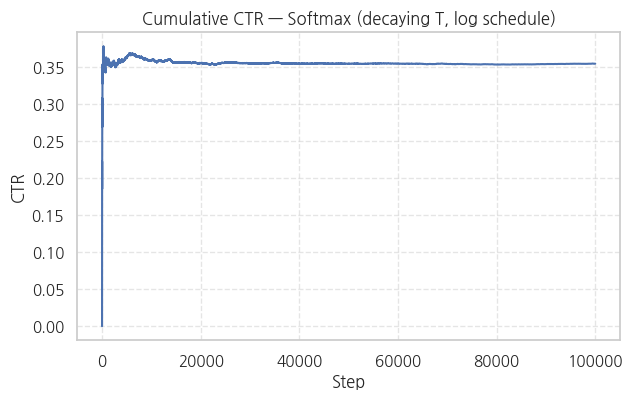

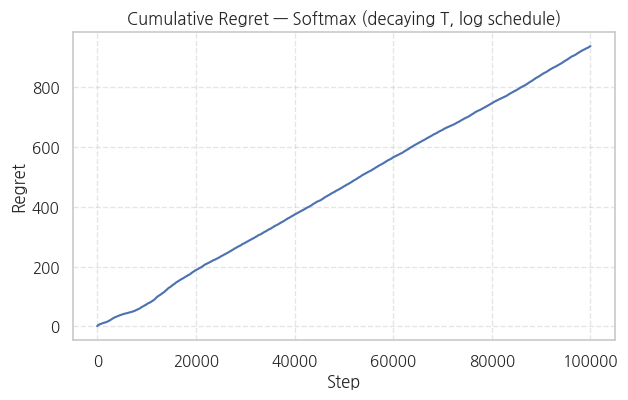

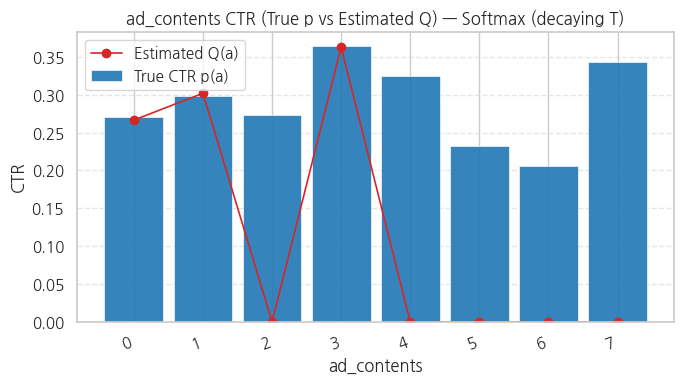

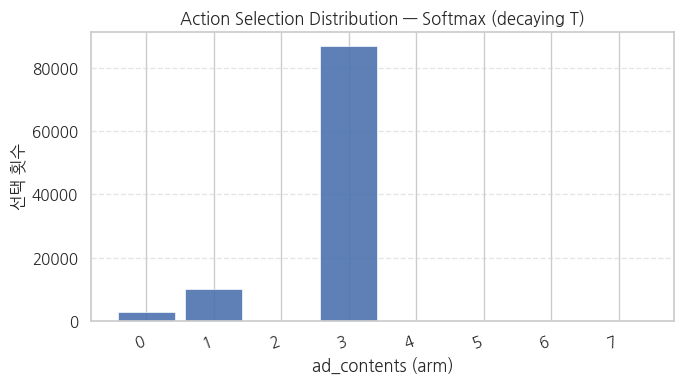

In [ ]:
# -*- coding: utf-8 -*-
"""
Stateless Softmax with decaying temperature on CSV (ad_contents, reward)

- 고정 T:          Regret = O(T)
- 감쇠형 T_t:      Regret = O(√T) ~ O(log T) (스케줄에 따라 상이)

여기서는 교재 스타일에 맞춰
    T_t ≈ C / log(t + offset)
형태의 로그 감쇠 스케줄을 사용.
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ==== [실험 파라미터] ====
PATH  = "Toss_preprocessed_FF.csv"
T     = 100_000
SEED  = 42

# 온도 로그 감쇠 스케줄 파라미터 (튜닝 후)
TEMP_SCALE  = 0.32    # 0.40 → 0.32 (전체적으로 더 낮게)
TEMP_OFFSET = 30.0    # 초반 온도 살짝 안정화
TEMP_MIN    = 0.015   # 하한 더 낮춰서 후반에 거의 greedy 수준
# ========================

np.random.seed(SEED)  # 에이전트용 난수 시드 고정

print(f"[PARAM] softmax_decay | T={T}, SCALE={TEMP_SCALE}, "
      f"OFFSET={TEMP_OFFSET}, T_MIN={TEMP_MIN}, SEED={SEED}, PATH='{PATH}'")

def load_bandit_from_csv(path, ad_col="ad_contents", reward_col="reward", seed=SEED):
    rng = np.random.default_rng(seed)   # 환경용 난수 시드
    df = pd.read_csv(path)
    assert {ad_col, reward_col}.issubset(df.columns)
    df = df[df[reward_col].isin([0, 1])].copy()

    # 라벨 → 0..K-1
    arms, inv = np.unique(df[ad_col].values, return_inverse=True)
    df["_arm"] = inv

    # 팔별 CTR 추정 (Laplace smoothing)
    g = df.groupby("_arm")[reward_col].agg(n="count", clicks="sum")
    p = ((g["clicks"] + 1) / (g["n"] + 2)).to_numpy(dtype=float)
    labels = arms.tolist()

    def step(a: int) -> int:
        return int(rng.random() < p[a])

    return p, labels, step

# ==== 온도 스케줄 정의 (로그 감쇠) ====
def temp_t(t: int) -> float:
    """
    T_t = max(T_MIN, TEMP_SCALE / log(t + TEMP_OFFSET))
    - t가 커질수록 서서히 감소
    - T_MIN 이하로는 떨어지지 않게 하한 설정
    """
    return max(TEMP_MIN, TEMP_SCALE / np.log(t + TEMP_OFFSET))

# ==== 환경 준비 ====
p, labels, step = load_bandit_from_csv(PATH, seed=SEED)
K      = len(p)
p_star = float(p.max())
print(f"[ENV] #arms={K}, p*={p_star:.4f}, mean(p)={p.mean():.4f}")

# 상태 변수
n  = np.zeros(K, int)    # 선택 횟수
s  = np.zeros(K, float)  # 누적 보상
Q  = np.zeros(K, float)  # 추정 CTR
ctr_curve    = np.zeros(T)
regret_curve = np.zeros(T)

def choose(T_curr: float) -> int:
    """Softmax(Q / T_curr)로 확률적으로 팔 선택"""
    z = Q / max(T_curr, 1e-6)  # 0 나눗셈 방지
    z -= z.max()               # overflow 방지
    prob = np.exp(z)
    prob /= prob.sum()
    return int(np.random.choice(K, p=prob))

# ==== 메인 루프 ====
for t in range(1, T + 1):
    T_curr = temp_t(t)            # 현재 step의 온도
    a      = choose(T_curr)
    r      = step(a)

    n[a] += 1
    s[a] += r
    Q[a]  = s[a] / n[a]

    ctr_curve[t - 1]    = s.sum() / t
    regret_curve[t - 1] = (p_star - p[a]) + (0 if t == 1 else regret_curve[t - 2])

print(f"[Softmax decaying-T] final CTR={ctr_curve[-1]:.4f} (best={p_star:.4f})")

# ==== 시각화 ====
# 1) 누적 CTR
plt.figure(figsize=(7, 4))
plt.plot(ctr_curve)
plt.title("Cumulative CTR — Softmax (decaying T, log schedule)")
plt.xlabel("Step"); plt.ylabel("CTR")
plt.grid(True, ls="--", alpha=0.5)
plt.show()

# 2) 누적 Regret
plt.figure(figsize=(7, 4))
plt.plot(regret_curve)
plt.title("Cumulative Regret — Softmax (decaying T, log schedule)")
plt.xlabel("Step"); plt.ylabel("Regret")
plt.grid(True, ls="--", alpha=0.5)
plt.show()

# 3) Q값 수렴: 팔별 True CTR vs Estimated Q
order    = np.arange(K)  # 필요하면 np.argsort(-p)로 정렬 가능
p_plot   = p[order]
Q_plot   = Q[order]
labs     = [str(labels[i]) for i in order]
x        = np.arange(K)

plt.figure(figsize=(7, 4))
plt.bar(
    x, p_plot,
    width=0.85,
    alpha=0.9,
    edgecolor="white",
    linewidth=0.5,
    color="tab:blue",
    label="True CTR p(a)"
)
plt.plot(
    x, Q_plot,
    marker="o",
    linewidth=1.2,
    color="tab:red",
    label="Estimated Q(a)"
)
plt.xticks(x, labs, rotation=20, ha="right")
plt.xlabel("ad_contents"); plt.ylabel("CTR")
plt.title("ad_contents CTR (True p vs Estimated Q) — Softmax (decaying T)")
plt.grid(True, axis="y", ls="--", alpha=0.5)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# 4) Action Selection Distribution — Softmax (decaying T)
n_plot = n[order]

plt.figure(figsize=(7, 4))
plt.bar(
    x, n_plot,
    width=0.85,
    alpha=0.9,
    edgecolor="white",
    linewidth=0.5
)
plt.xticks(x, labs, rotation=20, ha="right")
plt.xlabel("ad_contents (arm)")
plt.ylabel("선택 횟수")
plt.title("Action Selection Distribution — Softmax (decaying T)")
plt.grid(True, axis="y", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


#결과저장
np.savez(
    "/content/softmax_decay_result.npz",
    name="Softmax(감쇠형)",
    ctr_curve=ctr_curve,
    regret_curve=regret_curve,
    Q=Q,
    n=n,
    p=p,
    labels=np.array(labels),
    final_ctr=float(ctr_curve[-1]),
    p_star=float(p_star)
)


#UCB

[PARAM] ucb | T=100000, C=1.0, SEED=42, PATH='Toss_preprocessed_FF.csv'
[ENV] #arms=8, p*=0.3644, mean(p)=0.2894
[UCB] final CTR=0.3546 (best=0.3644)


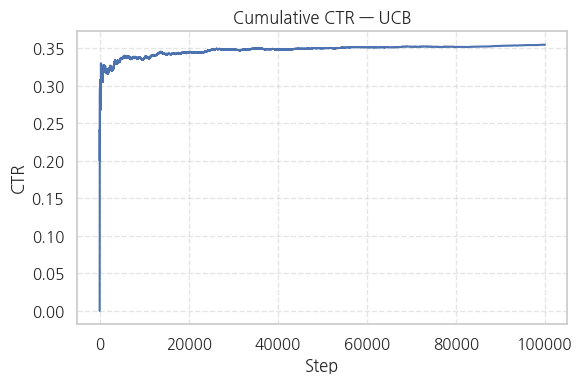

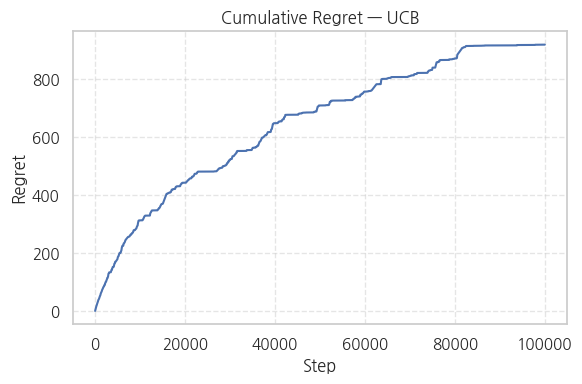

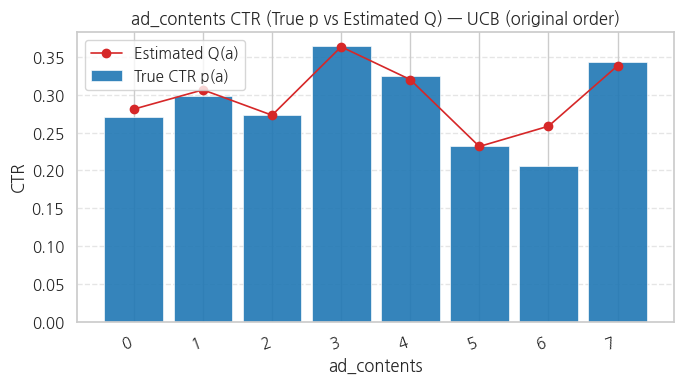

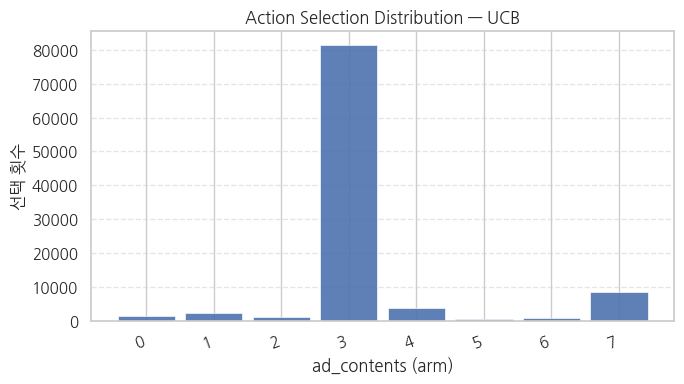


[ARM SUMMARY]
  ad_contents  true_ctr_p  plays_n  clicks  estimated_Q
           3    0.364375    81380   29582     0.363505
           7    0.343765     8524    2884     0.338339
           4    0.324853     3820    1223     0.320157
           1    0.299021     2456     753     0.306596
           2    0.273414     1106     302     0.273056
           0    0.270500     1302     366     0.281106
           5    0.232973      561     130     0.231729
           6    0.206483      851     220     0.258519


In [ ]:
# -*- coding: utf-8 -*-
"""
Stateless UCB on CSV (ad_contents, reward)

[실험 파라미터]
- PATH : CSV 경로 (ad_contents, reward 포함)
- T    : 총 스텝 수
- C    : 탐색 상수 (보상 상한이 1인 베르누이에서 0.5~1.5 추천)
- SEED : 난수 시드

[시각화]
  1) Cumulative CTR (누적 클릭률)
  2) Cumulative Regret (누적 후회도)
  3) 팔별 True CTR vs 학습된 Q값
  4) Action Selection Distribution (팔 선택 분포)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== [실험 파라미터] ===========================================
PATH = "Toss_preprocessed_FF.csv"
T    = 100_000
C    = 1.00      # 탐색 보너스 크기: 과탐색이면 줄이고, 과소탐색이면 키움
SEED = 42

SORT_ARMS = False  # True: 실제 CTR 내림차순 정렬 / False: 원래 순서
# ============================================================

print(f"[PARAM] ucb | T={T}, C={C}, SEED={SEED}, PATH='{PATH}'")


def load_bandit_from_csv(path, ad_col="ad_contents", reward_col="reward", seed=SEED):
    """
    CSV → 팔별 베르누이 확률 p(a) 추정 + step 함수 생성

    - ad_col     : 광고 컨텐츠 ID 컬럼
    - reward_col : 클릭 여부(0/1) 컬럼
    - 반환값:
        p      : 각 팔의 CTR 추정값 (Laplace smoothing)
        labels : 팔 라벨 리스트
        step   : a를 넣으면 0/1 보상을 샘플링하는 함수
    """
    rng = np.random.default_rng(seed)
    df = pd.read_csv(path)
    assert {ad_col, reward_col}.issubset(df.columns)
    df = df[df[reward_col].isin([0, 1])].copy()

    # ad_contents → 0..K-1 인덱스 매핑
    arms, inv = np.unique(df[ad_col].values, return_inverse=True)
    df["_arm"] = inv

    # Laplace smoothing: (clicks+1)/(n+2)
    g = df.groupby("_arm")[reward_col].agg(n="count", clicks="sum")
    p = ((g["clicks"] + 1) / (g["n"] + 2)).to_numpy(dtype=float)
    labels = arms.tolist()

    def step(a: int) -> int:
        return int(rng.random() < p[a])

    return p, labels, step


# ===================== 환경 준비 =====================
p, labels, step = load_bandit_from_csv(PATH, seed=SEED)
K      = len(p)
p_star = float(p.max())
print(f"[ENV] #arms={K}, p*={p_star:.4f}, mean(p)={p.mean():.4f}")

# 상태 변수
n = np.zeros(K, dtype=int)    # 팔별 선택 횟수
s = np.zeros(K, dtype=float)  # 팔별 누적 보상
Q = np.zeros(K, dtype=float)  # 팔별 추정 CTR (평균 보상)

ctr_curve    = np.zeros(T)    # 누적 CTR
regret_curve = np.zeros(T)    # 누적 Regret
t_global     = 0              # 전체 스텝 카운터 (log 항에서 사용)


def choose() -> int:
    """
    UCB 선택 규칙 (UCB1 형태)
      a_t = argmax_a [ Q[a] + C * sqrt( ln t / n[a] ) ]

    - 모든 팔을 최소 1회씩 선택하여 n[a]=0 분모 문제 방지
    """
    global t_global
    t_global += 1

    # 워밍업: 아직 한 번도 선택되지 않은 팔이 있으면 그 팔부터 순서대로 선택
    for a in range(K):
        if n[a] == 0:
            return a

    # 탐색 보너스 항
    bonus = C * np.sqrt(np.log(t_global) / n)
    # 동률이 있어도 argmax는 아무거나 골라주므로 그대로 사용
    return int(np.argmax(Q + bonus))


# ===================== 메인 루프 =====================
for t in range(1, T + 1):
    a = choose()
    r = step(a)

    # 샘플 평균 업데이트
    n[a] += 1
    s[a] += r
    Q[a] = s[a] / n[a]

    # 누적 CTR / Regret 업데이트
    ctr_curve[t - 1]    = s.sum() / t
    regret_curve[t - 1] = (p_star - p[a]) + (0 if t == 1 else regret_curve[t - 2])

print(f"[UCB] final CTR={ctr_curve[-1]:.4f} (best={p_star:.4f})")

# ===================== 시각화 =====================

# 1) Cumulative CTR
plt.figure(figsize=(6, 4))
plt.plot(ctr_curve)
plt.title("Cumulative CTR — UCB")
plt.xlabel("Step")
plt.ylabel("CTR")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 2) Cumulative Regret
plt.figure(figsize=(6, 4))
plt.plot(regret_curve)
plt.title("Cumulative Regret — UCB")
plt.xlabel("Step")
plt.ylabel("Regret")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 3) 팔별 True CTR vs Estimated Q (정렬 옵션 포함)
if SORT_ARMS:
    order = np.argsort(-p)   # 실제 CTR 내림차순
    suffix = "(sorted by True CTR)"
else:
    order = np.arange(K)     # 원래 순서 유지
    suffix = "(original order)"

p_plot    = p[order]
Q_plot    = Q[order]
labs_plot = [str(labels[i]) for i in order]
x         = np.arange(K)

plt.figure(figsize=(7, 4))

# 파란 막대: 실제 CTR p(a)
plt.bar(
    x, p_plot,
    width=0.85,
    alpha=0.9,
    edgecolor="white",
    linewidth=0.5,
    color="tab:blue",
    label="True CTR p(a)"
)

# 빨간 선 + 동그라미: 학습된 Q(a)
plt.plot(
    x, Q_plot,
    marker="o",
    linewidth=1.2,
    color="tab:red",
    label="Estimated Q(a)"
)

plt.xticks(x, labs_plot, rotation=20, ha="right")
plt.xlabel("ad_contents")
plt.ylabel("CTR")
plt.title(f"ad_contents CTR (True p vs Estimated Q) — UCB {suffix}")
plt.grid(True, axis="y", ls="--", alpha=0.5)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# 4) Action Selection Distribution — 팔 선택 분포
n_plot    = n[order]                 # 위에서 사용한 order와 동일하게 정렬
labs_plot = [str(labels[i]) for i in order]
x         = np.arange(K)

plt.figure(figsize=(7, 4))
plt.bar(
    x, n_plot,
    width=0.85,
    alpha=0.9,
    edgecolor="white",
    linewidth=0.5
)
plt.xticks(x, labs_plot, rotation=20, ha="right")
plt.xlabel("ad_contents (arm)")
plt.ylabel("선택 횟수")
plt.title("Action Selection Distribution — UCB")
plt.grid(True, axis="y", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# (선택) 팔별 요약 테이블 출력
summary = pd.DataFrame({
    "ad_contents": [labels[i] for i in range(K)],
    "true_ctr_p":  p,
    "plays_n":     n,
    "clicks":      s.astype(int),
    "estimated_Q": Q,
}).sort_values("true_ctr_p", ascending=False)

print("\n[ARM SUMMARY]\n", summary.to_string(index=False))


#결과저장
import numpy as np

np.savez(
    "/content/ucb_result.npz",
    name="UCB",
    ctr_curve=ctr_curve,
    regret_curve=regret_curve,
    Q=Q,
    n=n,
    p=p,
    labels=np.array(labels),
    final_ctr=float(ctr_curve[-1]),
    p_star=float(p_star)
)


#Thompson Sampling

[PARAM] thompson | T=100000, A0=1.0, B0=1.0, SEED=42, PATH='Toss_preprocessed_FF.csv'
[ENV] #arms=8, p*=0.3644, mean(p)=0.2894
[Thompson] final CTR=0.3609 (best=0.3644)


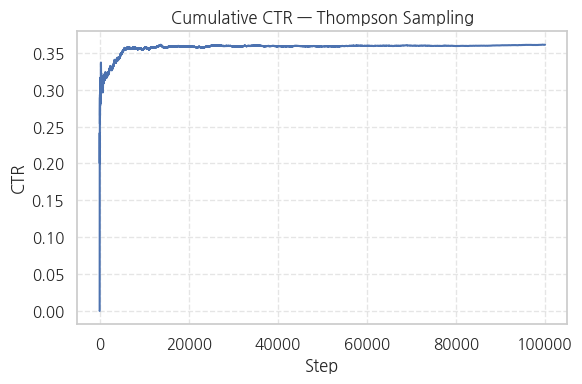

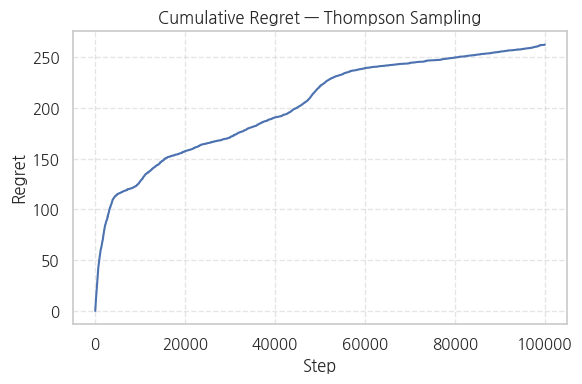

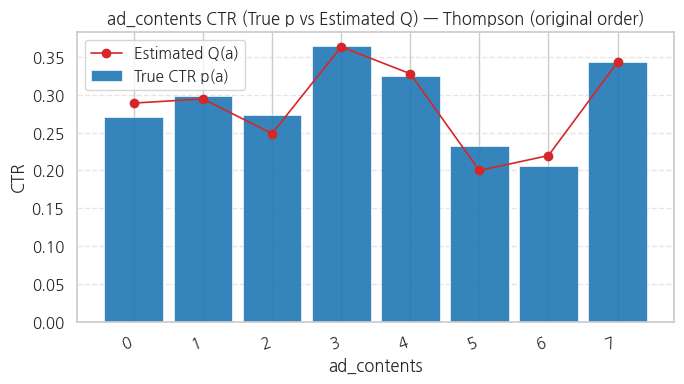

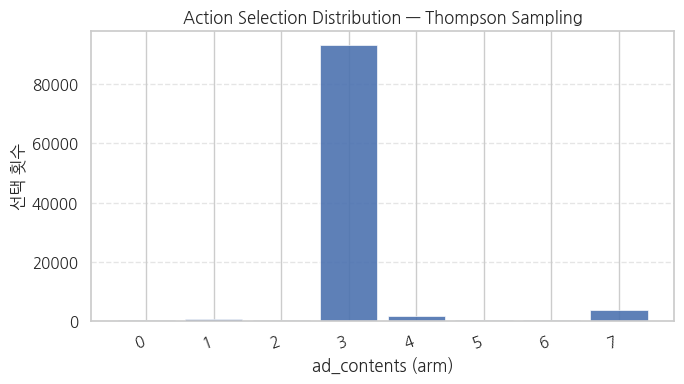


[ARM SUMMARY]
  ad_contents  true_ctr_p  plays_n  clicks  estimated_Q   alpha    beta
           3    0.364375    93276   33903     0.363470 33904.0 59374.0
           7    0.343765     3707    1272     0.343135  1273.0  2436.0
           4    0.324853     1726     566     0.327926   567.0  1161.0
           1    0.299021      550     162     0.294545   163.0   389.0
           2    0.273414      205      51     0.248780    52.0   155.0
           0    0.270500      294      85     0.289116    86.0   210.0
           5    0.232973      110      22     0.200000    23.0    89.0
           6    0.206483      132      29     0.219697    30.0   104.0


In [ ]:
# -*- coding: utf-8 -*-
"""
Stateless Thompson Sampling on CSV (ad_contents, reward)

[실험 파라미터]
- PATH : CSV 경로 (ad_contents, reward 포함)
- T    : 총 스텝 수
- A0,B0: Beta 사전 분포 파라미터(α, β) — 비편향 기본값 1,1 권장
- SEED : 난수 시드

[시각화]
  1) Cumulative CTR (누적 클릭률)
  2) Cumulative Regret (누적 후회도)
  3) 팔별 True CTR vs 학습된 Q값
  4) Action Selection Distribution (팔 선택 분포)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== [실험 파라미터] ===========================================
PATH = "Toss_preprocessed_FF.csv"
T    = 100_000
A0, B0 = 1.0, 1.0      # Beta(α, β) 사전분포 (비편향: 1,1)
SEED = 42

SORT_ARMS = False      # True: 실제 CTR 내림차순 정렬 / False: 원래 순서
# ============================================================

print(f"[PARAM] thompson | T={T}, A0={A0}, B0={B0}, SEED={SEED}, PATH='{PATH}'")


def load_bandit_from_csv(path, ad_col="ad_contents", reward_col="reward", seed=SEED):
    """
    CSV → 팔별 베르누이 확률 p(a) 추정 + step 함수 생성

    - ad_col     : 광고 컨텐츠 ID 컬럼
    - reward_col : 클릭 여부(0/1) 컬럼
    - 반환값:
        p      : 각 팔의 CTR 추정값 (Laplace smoothing)
        labels : 팔 라벨 리스트
        step   : a를 넣으면 0/1 보상을 샘플링하는 함수
    """
    rng = np.random.default_rng(seed)
    df = pd.read_csv(path)
    assert {ad_col, reward_col}.issubset(df.columns)
    df = df[df[reward_col].isin([0, 1])].copy()

    # ad_contents → 0..K-1 인덱스 매핑
    arms, inv = np.unique(df[ad_col].values, return_inverse=True)
    df["_arm"] = inv

    # Laplace smoothing: (clicks+1)/(n+2)
    g = df.groupby("_arm")[reward_col].agg(n="count", clicks="sum")
    p = ((g["clicks"] + 1) / (g["n"] + 2)).to_numpy(dtype=float)
    labels = arms.tolist()

    def step(a: int) -> int:
        return int(rng.random() < p[a])

    return p, labels, step


# ===================== 환경 준비 =====================
p, labels, step = load_bandit_from_csv(PATH, seed=SEED)
K      = len(p)
p_star = float(p.max())
print(f"[ENV] #arms={K}, p*={p_star:.4f}, mean(p)={p.mean():.4f}")

# Beta-베르누이 분포 파라미터 (사전 → 사후)
alpha = np.ones(K) * A0
beta  = np.ones(K) * B0

# 상태 변수
n = np.zeros(K, dtype=int)    # 팔별 선택 횟수
s = np.zeros(K, dtype=float)  # 팔별 누적 보상
Q = np.zeros(K, dtype=float)  # 팔별 추정 CTR (평균 보상)

ctr_curve    = np.zeros(T)    # 누적 CTR
regret_curve = np.zeros(T)    # 누적 Regret

# 정책 샘플링용 난수 생성기 (환경용과 분리)
rng_policy = np.random.default_rng(SEED + 1)


def choose() -> int:
    """
    Thompson Sampling 선택 규칙

    - 각 팔 a에 대해 θ_a ~ Beta(α_a, β_a) 샘플링
    - θ_a가 가장 큰 팔을 선택
    - 불확실성이 큰 팔(alpha, beta가 작을수록 분산↑)이
      초기에 더 자주 선택되어 '확률적 탐색'이 이루어짐
    """
    theta = rng_policy.beta(alpha, beta)
    return int(np.argmax(theta))


# ===================== 메인 루프 =====================
for t in range(1, T + 1):
    a = choose()
    r = step(a)

    # 관측 기반 빈도 / 평균 업데이트
    n[a] += 1
    s[a] += r
    Q[a] = s[a] / n[a]

    # Beta 분포 파라미터 업데이트 (성공 r, 실패 1-r)
    alpha[a] += r
    beta[a]  += (1 - r)

    # 누적 CTR / Regret 업데이트
    ctr_curve[t - 1]    = s.sum() / t
    regret_curve[t - 1] = (p_star - p[a]) + (0 if t == 1 else regret_curve[t - 2])

print(f"[Thompson] final CTR={ctr_curve[-1]:.4f} (best={p_star:.4f})")


# ===================== 시각화 =====================

# 1) Cumulative CTR
plt.figure(figsize=(6, 4))
plt.plot(ctr_curve)
plt.title("Cumulative CTR — Thompson Sampling")
plt.xlabel("Step")
plt.ylabel("CTR")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 2) Cumulative Regret
plt.figure(figsize=(6, 4))
plt.plot(regret_curve)
plt.title("Cumulative Regret — Thompson Sampling")
plt.xlabel("Step")
plt.ylabel("Regret")
plt.grid(True, ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 3) 팔별 True CTR vs Estimated Q (정렬 옵션 포함)
if SORT_ARMS:
    order = np.argsort(-p)   # 실제 CTR 내림차순
    suffix = "(sorted by True CTR)"
else:
    order = np.arange(K)     # 원래 순서 유지
    suffix = "(original order)"

p_plot    = p[order]
Q_plot    = Q[order]
labs_plot = [str(labels[i]) for i in order]
x         = np.arange(K)

plt.figure(figsize=(7, 4))

# 파란 막대: 실제 CTR p(a)
plt.bar(
    x, p_plot,
    width=0.85,
    alpha=0.9,
    edgecolor="white",
    linewidth=0.5,
    color="tab:blue",
    label="True CTR p(a)"
)

# 빨간 선 + 동그라미: 학습된 Q(a)
plt.plot(
    x, Q_plot,
    marker="o",
    linewidth=1.2,
    color="tab:red",
    label="Estimated Q(a)"
)

plt.xticks(x, labs_plot, rotation=20, ha="right")
plt.xlabel("ad_contents")
plt.ylabel("CTR")
plt.title(f"ad_contents CTR (True p vs Estimated Q) — Thompson {suffix}")
plt.grid(True, axis="y", ls="--", alpha=0.5)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

# 4) Action Selection Distribution — 팔 선택 분포
n_plot    = n[order]
labs_plot = [str(labels[i]) for i in order]
x         = np.arange(K)

plt.figure(figsize=(7, 4))
plt.bar(
    x, n_plot,
    width=0.85,
    alpha=0.9,
    edgecolor="white",
    linewidth=0.5
)
plt.xticks(x, labs_plot, rotation=20, ha="right")
plt.xlabel("ad_contents (arm)")
plt.ylabel("선택 횟수")
plt.title("Action Selection Distribution — Thompson Sampling")
plt.grid(True, axis="y", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# (선택) 팔별 요약 테이블 출력
summary = pd.DataFrame({
    "ad_contents": [labels[i] for i in range(K)],
    "true_ctr_p":  p,
    "plays_n":     n,
    "clicks":      s.astype(int),
    "estimated_Q": Q,
    "alpha":       alpha,
    "beta":        beta,
}).sort_values("true_ctr_p", ascending=False)

print("\n[ARM SUMMARY]\n", summary.to_string(index=False))



#결과저장

np.savez(
    "/content/thompson_result.npz",
    name="Thompson Sampling",
    ctr_curve=ctr_curve,
    regret_curve=regret_curve,
    Q=Q,
    n=n,
    p=p,
    labels=np.array(labels),
    final_ctr=float(ctr_curve[-1]),
    p_star=float(p_star)
)


#Total

[ENV] #arms=8, p*=0.3644, mean(p)=0.2894


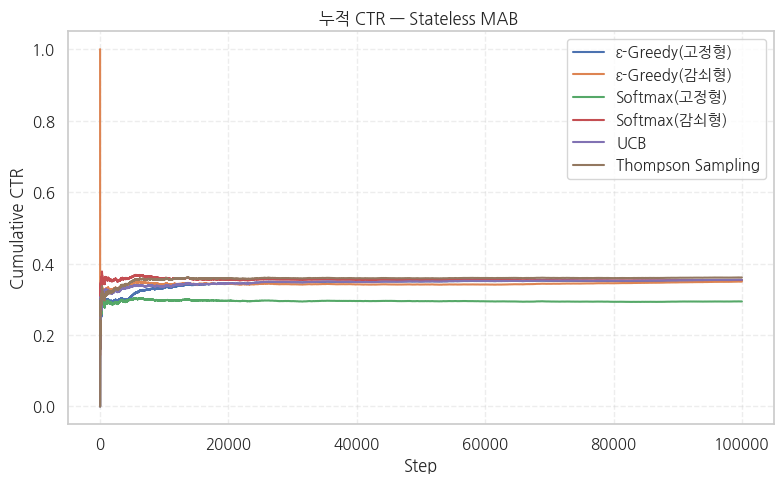

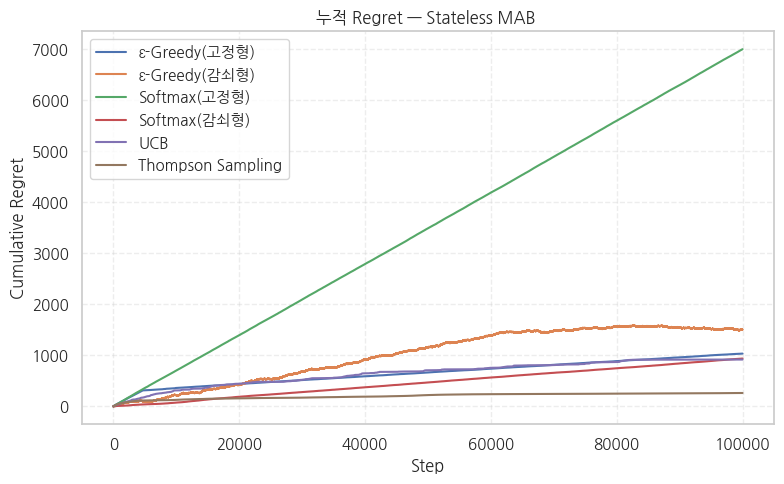

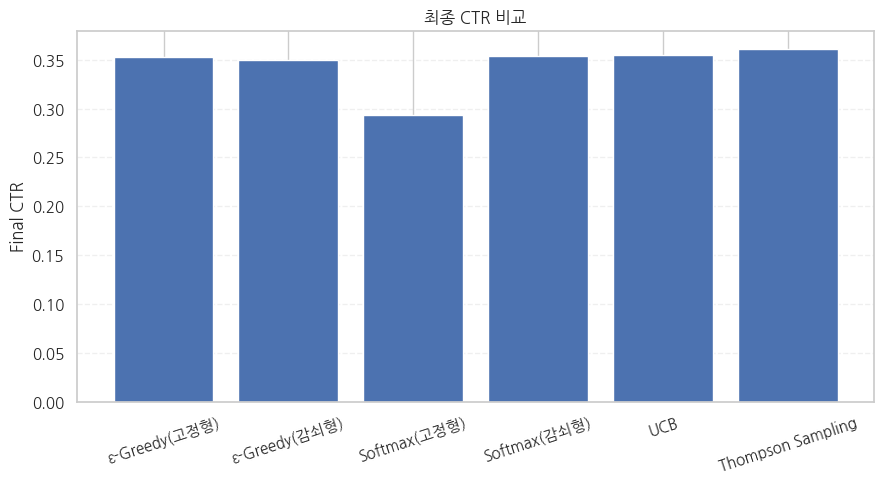

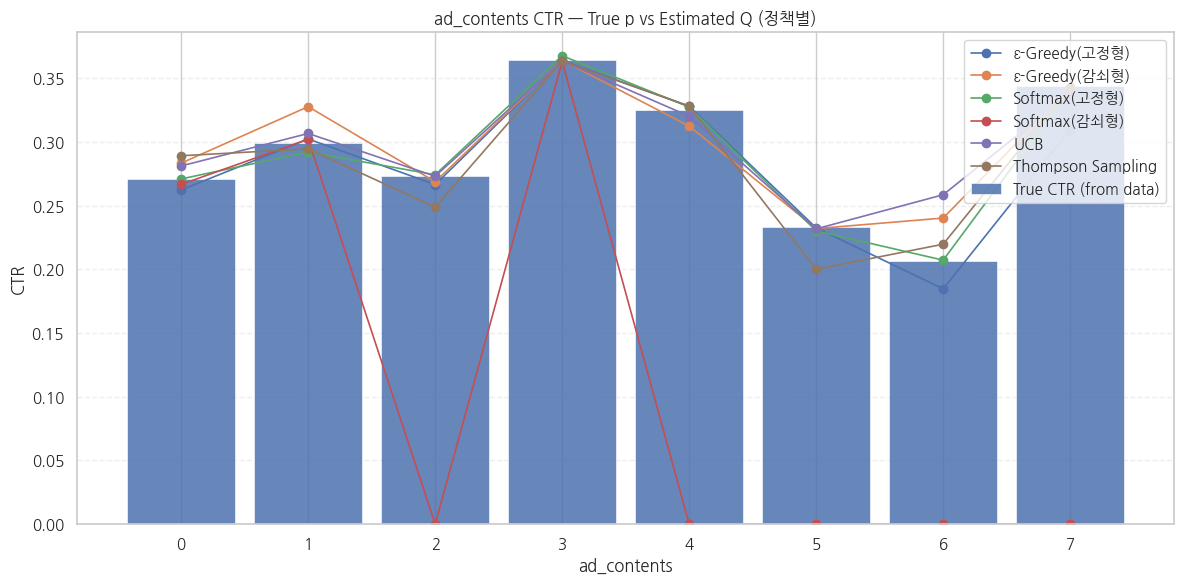

[INFO] #Arms = 8 p* = 0.3644 mean p = 0.2894
ε-Greedy(고정형)          | Final CTR = 0.3529
ε-Greedy(감쇠형)          | Final CTR = 0.3493
Softmax(고정형)           | Final CTR = 0.2939
Softmax(감쇠형)           | Final CTR = 0.3541
UCB                    | Final CTR = 0.3546
Thompson Sampling      | Final CTR = 0.3609


In [ ]:
# -*- coding: utf-8 -*-
"""
Toss Ads — MAB 결과 통합 시각화 (학습 X, 결과 파일 로드만)
각 알고리즘별 npz 결과 파일을 미리 만들어 두고,
- 누적 CTR
- 누적 Regret
- 최종 CTR 막대
- 팔별 True p vs Q (정책별)
를 한 번에 그려줌.
"""

import numpy as np
import matplotlib.pyplot as plt

# 1) 여기 리스트에 알고리즘별 결과 파일 경로를 적어둠
RESULT_FILES = [
    "/content/eps_fixed_result.npz",
    "/content/eps_decay_result.npz",
    "/content/softmax_fixed_result.npz",
    "/content/softmax_decay_result.npz",
    "/content/ucb_result.npz",
    "/content/thompson_result.npz",
]

results = []
p = None
labels = None
p_star = None

for path in RESULT_FILES:
    data = np.load(path, allow_pickle=True)
    name         = str(data["name"])
    ctr_curve    = data["ctr_curve"]
    regret_curve = data["regret_curve"]
    Q            = data["Q"]
    n            = data["n"]

    # 공통 환경 정보는 첫 번째 파일에서만 가져오고, 나머지는 체크만
    if p is None:
        p       = data["p"]
        labels  = data["labels"]
        p_star  = float(data["p_star"])
    else:
        # 안전하게 p*이 같은지 등 확인할 수도 있음 (선택)
        pass

    results.append({
        "name": name,
        "ctr": ctr_curve,
        "regret": regret_curve,
        "Q": Q,
        "n": n,
    })

K = len(p)
print(f"[ENV] #arms={K}, p*={p_star:.4f}, mean(p)={p.mean():.4f}")

# ==================== 1) 누적 CTR ====================
plt.figure(figsize=(8, 5))
for r in results:
    plt.plot(r["ctr"], label=r["name"])
plt.title("누적 CTR — Stateless MAB ")
plt.xlabel("Step")
plt.ylabel("Cumulative CTR")
plt.grid(True, ls="--", alpha=.35)
plt.legend()
plt.tight_layout()
plt.show()

# ==================== 2) 누적 Regret ====================
plt.figure(figsize=(8, 5))
for r in results:
    plt.plot(r["regret"], label=r["name"])
plt.title("누적 Regret — Stateless MAB ")
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.grid(True, ls="--", alpha=.35)
plt.legend()
plt.tight_layout()
plt.show()

# ==================== 3) 최종 CTR 막대 ====================
names = [r["name"] for r in results]
final_ctrs = [float(r["ctr"][-1]) for r in results]

plt.figure(figsize=(9, 5))
plt.bar(names, final_ctrs)
plt.title("최종 CTR 비교")
plt.ylabel("Final CTR")
plt.xticks(rotation=18)
plt.grid(True, axis="y", ls="--", alpha=.3)
plt.tight_layout()
plt.show()

# ==================== 4) 팔별 True p vs 정책별 Q ====================
SORT_ARMS = False
order = np.argsort(-p) if SORT_ARMS else np.arange(K)
x     = np.arange(K)
labs  = [str(l) for l in labels[order]]

plt.figure(figsize=(12, 6))
plt.bar(
    x, p[order],
    width=0.85,
    alpha=0.85,
    edgecolor="white",
    linewidth=0.5,
    label="True CTR (from data)"
)
for r in results:
    plt.plot(
        x, r["Q"][order],
        marker="o",
        linewidth=1.2,
        label=r["name"]
    )

plt.xticks(x, labs)
plt.xlabel("ad_contents")
plt.ylabel("CTR")
plt.title("ad_contents CTR — True p vs Estimated Q (정책별)")
plt.grid(True, axis="y", linestyle="--", alpha=.35)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ==================== 5) 텍스트 요약 ====================
print("[INFO] #Arms =", K,
      "p* =", round(float(p_star), 4),
      "mean p =", round(float(p.mean()), 4))
for r in results:
    print(f"{r['name']:<22s} | Final CTR = {r['ctr'][-1]:.4f}")
